In [ ]:
"""
Cin Aquino's contribution to a project submitted in Winter Quarter 2023 
as part of a Dr. Aaron Meyer's Bioengineering 175 final project at UCLA. 
Presentation was cleaned up and text added to help with interpretability of results.
(Project collaborators who worked on other figures: Susanna Ferrier, Leon Wu, and Lauren Hunter) 

Code presented was used for recreating figures 2A, 2D, 3A,
and 3B from (Galit et al 2018): https://www.embopress.org/doi/full/10.15252/msb.20177881

Also includes the cross validation and implementation of a 4-class
random forest classifier to compare its performance with a multinomial 

4-class Logistic Regression model

"""

# Introduction (copied/edited from the final report)

Preventative measures for infectious disease, such as vaccinations, have been an important field of study in recent years, especially with COVID-19. However, there are still many infectious agents missing effective vaccine treatments, due to A) traditional vaccination methods not providing broad immunity to disease and B) some traditional predictors of immunity not being as sufficient at predicting immunity as previously thought.

For HIV-infected patients who are not undergoing antiviral treatments, some may have varying degrees of “spontaneous immunity”, which is believed to be related to the antibody measurements of a given patient. The paper [*High-resolution definition of humoral immune response correlates of effective immunity against HIV* (Galit et al. 2018)](https://www.embopress.org/doi/full/10.15252/msb.20177881) used methods similar to those covered in Bioengineering 175, to study the correlation between antibody structure/function and recorded humoral responses in a given patient. We aimed to reimplement the analyses carried out by Galit et al, while attempting other modeling techniques as an extension of the analysis. Since this is a reimplementation, the methods and models used have been tried by the authors of the original paper. We are unaware of any other parties that have done similar analyses.


# Preprocessing/Loading the data

Reading and processing the datasets into a form that could be used by the Logistic Regression model. To do this, we label encoded patient class categorical predictor variables (stored in ../meta/subjects.csv) and standardized the data (by zscoring data by column)

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import confusion_matrix
import scipy as sp
from scipy.stats import ttest_ind
import warnings

# suppresses warning: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
# that occurs during logistic regression
warnings.filterwarnings("ignore")

# classses to predict
y = pd.read_csv("./dataset_EV1/meta/subjects.csv").set_index("Unnamed: 0") # sets the index to "Unnamed 0" to match data points in X later
print(len(pd.read_csv("./dataset_EV1/data/function.csv")))

func = pd.read_csv("./dataset_EV1/data/function.csv").set_index("Unnamed: 0") # sets labels to index
glyc = pd.read_csv("./dataset_EV1/data/glycan-gp120.csv").set_index("Unnamed: 0")
lumigg = pd.read_csv("./dataset_EV1/data/luminex-igg.csv").set_index("Unnamed: 0")
lumi =pd.read_csv("./dataset_EV1/data/luminex.csv").set_index("Unnamed: 0")

# combines all of the above AND the y array, to match up the indeces with the data points automatically
pre_X = pd.concat([func,glyc,lumigg,lumi,y],axis = 1) 

#Final arrays where y only contains the label data,  and X only has the numeric data
y = pre_X[["class.etuv","class.cp","class.nv"]]
X = pre_X.drop(["class.etuv","class.cp","class.nv"],axis = 1)

181


### Patient classes 

In [3]:
y

,class.etuv,class.cp,class.nv
Unnamed: 0,,,
100681,EC,controller,nonviremic
101013,TP,progressor,nonviremic
103797,VC,controller,viremic
107889,TP,progressor,nonviremic
109477,EC,controller,nonviremic
...,...,...,...
976531,EC,controller,nonviremic
985170,TP,progressor,nonviremic
987427,VC,controller,viremic


### All data from the data folder in dataset_EV1/data combined into one Pandas dataframe

In [4]:
X

,ADCD,ADCC,ADNP,CD107a,IFNy,MIP1b,G2FB,G2F,G2B,G1FB,...,SNA.HIV1.Nef,SNA.HIV1.Rev,SNA.p24.HXBc2,VVL.gp120.BAL,VVL.gp140.CN54,VVL.gp41.HXBc2,VVL.HIV1.Integrase,VVL.HIV1.Nef,VVL.HIV1.Rev,VVL.p24.HXBc2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
100681,2.84,5.60,14.79,5.20,3.71,16.15,0.1,9.8,0.7,3.5,...,6452.0,8065.0,65227.0,7.0,-16.5,-7001.5,-9.0,-62.5,-15.5,-8.0
101013,2.46,17.53,16.31,9.26,6.58,25.19,0.7,7.6,0.5,7.0,...,-1608.5,-283.5,-494.5,21.5,-11.0,-3046.5,527.0,-9.5,-22.0,-4.0
103797,3.18,19.33,33.81,16.99,13.16,56.03,0.3,4.4,0.2,10.8,...,-162.0,-305.0,6138.0,216.0,30.5,10499.5,778.0,34.0,-10.0,9.0
107889,0.06,18.14,26.67,8.60,4.75,23.98,NaN,NaN,NaN,NaN,...,-1681.0,169.0,-604.0,24.0,3.5,-1566.0,35.0,-14.0,-18.5,-5.0
109477,1.65,14.74,25.70,15.15,10.68,40.12,NaN,NaN,NaN,NaN,...,380.0,1343.0,6564.0,40.0,28.0,1133.0,392.0,-30.5,-34.0,71.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976531,1.35,5.65,53.15,11.68,8.65,49.77,0.8,8.2,0.4,10.3,...,927.0,6998.0,7804.0,28.0,-19.0,-3547.5,-5.0,6.5,-32.5,-14.0
985170,1.24,14.64,10.97,15.22,8.10,28.99,0.1,5.3,0.7,5.8,...,-1712.0,59390.0,-1885.0,21.5,61.5,373.5,183.0,31.5,-19.0,-29.5
987427,2.29,12.81,32.57,10.95,7.36,40.98,NaN,NaN,NaN,NaN,...,2674.0,-196.0,8539.0,40.5,-5.0,5522.0,1081.0,5.5,-14.0,-2.0


In [5]:
# Preprocessing by impution

def process_data_etuv(X,y):
    """
    Converts inputted X and y
    dataframes into scaled/label encoded
    forms that can be used by the model
    
    X: an dataframe sorted by patient number, (the df indeces) of raw measurements 181 rows × 548 columns
    y: an dataframe sorted by patient number, for patient class (contains all of EC, viremic, controller, etc...)
    
    X_processed: a dataframe where all the data under each column/variable is scaled/zscored
    y_processed: a 1-D array for just controller/progressor classes,
    where each label of class.etuv is encoded as an integer 0-3
    """
    # Step 1: Imputing NaNs in X by setting them to the column mean
    imp_means = SimpleImputer(missing_values=np.nan, strategy='mean') #fills in NaNss
    X_processed = imp_means.fit_transform(X) # fills in nans within X_processed

    # # Step 1.5: scaling and centering each data point to a mean of 0 and a std dev of 1
    X_processed = pd.DataFrame(X_processed).apply(sp.stats.zscore)

    # Step 2: label encoding classes (y)
    le = LabelEncoder() #used for converting label data into numbers
    # only encodes and returns the encoded class labels under "class.etuv" column. Other columns
    # didn't matter for multinomial regression
    y_processed = np.array(le.fit_transform(y["class.etuv"])) 

    return X_processed, y_processed
X_processed, y_processed = process_data_etuv(X,y)
X_processed

,0,1,2,3,4,5,6,7,8,9,...,538,539,540,541,542,543,544,545,546,547
0,1.487939,-1.776257,-0.075466,-1.689876,-1.337246,-1.762574,-1.701868e+00,0.157752,0.435213,-1.005240e+00,...,1.943712,0.587111,7.727547,-0.268620,-0.742011,-1.630145,-0.515729,-2.824954,0.071649,-0.230714
1,1.132554,0.554901,0.090709,-0.510496,-0.462732,-0.987999,-8.523086e-02,-0.537775,-0.220954,4.783975e-01,...,-0.306800,-0.187494,-0.371596,-0.214244,-0.589440,-0.807274,-0.081580,-0.610123,-0.099682,-0.096224
2,1.805915,0.906626,2.003908,1.734974,1.542253,1.654470,-1.162989e+00,-1.549449,-1.205204,2.089204e+00,...,0.097067,-0.189489,0.445756,0.515154,0.561776,2.011084,0.121725,1.207710,0.216622,0.340870
3,-1.111980,0.674097,1.223323,-0.702218,-1.020349,-1.091675,5.982759e-16,0.000000,0.000000,3.764958e-16,...,-0.327042,-0.145509,-0.385090,-0.204868,-0.187208,-0.499244,-0.480090,-0.798175,-0.007427,-0.129846
4,0.375024,0.009726,1.117277,1.200477,0.786575,0.291251,5.982759e-16,0.000000,0.000000,3.764958e-16,...,0.248395,-0.036581,0.498254,-0.144866,0.492426,0.062305,-0.190927,-1.487698,-0.415987,2.442283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.094457,-1.766487,4.118265,0.192485,0.168015,1.118093,1.842086e-01,-0.348086,-0.549038,1.877256e+00,...,0.401118,0.488111,0.651064,-0.189868,-0.811361,-0.911512,-0.512490,0.058505,-0.376449,-0.432450
177,-0.008417,-0.009814,-0.493090,1.220811,0.000426,-0.662403,-1.701868e+00,-1.264916,0.435213,-3.027832e-02,...,-0.335697,5.349239,-0.542953,-0.214244,1.421721,-0.095715,-0.360213,1.103236,-0.020606,-0.953600
178,0.973567,-0.367401,1.868344,-0.019571,-0.225059,0.364938,5.982759e-16,0.000000,0.000000,3.764958e-16,...,0.888885,-0.179375,0.741641,-0.142991,-0.422999,0.975474,0.367149,0.016716,0.111187,-0.028979
179,0.038344,0.486510,2.625970,1.209192,0.533666,0.272401,-8.523086e-02,0.758433,-0.877121,4.783975e-01,...,-0.169292,-0.204659,-0.570927,1.726443,-0.450739,0.113488,-0.330244,-0.986227,-0.587318,-0.735053


# Figure 2A, Multinomal Accuracy

Controllers are people with HIV who are able to suppress the disease to untransmittable/undetectable levels, while progressors are patients with HIV that have progressed to transmissibility. Viremic and nonviremic (V,AV) indicates whether or not they have a transmissible level of HIV in their blood. The four class model patients included elite controllers, viremic controllers, treated progressors and untreated progressors (EC,VC,TP, and UP). The 4-class Multinomial Logistic Regression Classifier was applied to all the numerical data provided in the *data* folder in order to predict those four patient classes. The paper stated that they used an elastic net mixing parameter of 0.8 for regularization, so that same value was used as an argument here.

In [6]:
# Multinomial Logistic Regression Classifier. 
# in order to use the multinomial model, the documentation stated that we needed to use the "saga" solver. 
# l1_ratio represents the elastic net mixing parameter the paper used for presenting results (alpha = 0.8)

LR=LogisticRegression(multi_class = "multinomial",solver = "saga",penalty = "elasticnet",l1_ratio = .8)

In 2A, the authors took their best LR parameters, and did 100 iterations of 10-fold cross validtions on the processed data, each time recording the average cross validation score. They then created a boxplot with the data compared with the permutated data in order to guage its performance. 

In [7]:
kf = KFold(n_splits=10,shuffle = True)

avg_scores = [] #stores the average score of the 10 folds, for 100 different 10-folds

X_processed, y_processed = process_data_etuv(X,y)

# Cross validation scors for the 4-class part of 2A full model

for cv_iteration in range(100):
    k_10_scores = []
    for i, (train_index, test_index) in enumerate(kf.split(X_processed)):

        # random indeces for training set
        x_train = X_processed.loc[train_index]
        y_train = y_processed[train_index] # don't use loc ssince it's a 1D array

        # remaining indeces for test set
        x_test =  X_processed.loc[test_index]
        y_test = y_processed[test_index] 

        # Fits training set
        LR=LogisticRegression(multi_class = "multinomial",solver = "saga",penalty = "elasticnet",l1_ratio = .8)
        LR.fit(x_train,y_train)
        
        # Calculates the score for the current fold and adds it to k_10_scores
        k_10_scores.append(LR.score(x_test,y_test))
    
    #calculates the means of accuracies of the 10 folds and records it in avg_scores
    avg_scores.append(np.mean(np.array(k_10_scores)))

    

Permuted data represents the case where the data classes were "shuffled" between data points, and the model was then applied on this shuffled data. This represents a case where the model outputs data at random and helps validate the non-permuted model results

In [8]:
# Cross validation scoress for the 4-class part of 2A permuted data
score_rand = permutation_test_score(LR, X_processed, y_processed, scoring="accuracy", cv=kf, n_permutations=100)

# score_rand is a tuple, where the first item is an array of the scores for each cross validation 
# of permuted data
permuted_scores = score_rand[1] 


[Text(0.5, 1.0, '4-Class Logistic Regression Model'), Text(0, 0.5, 'Accuracy')]

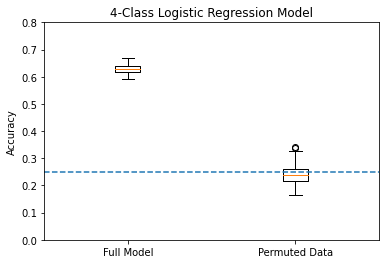

In [9]:
# plotting the permuted and full model data
# the blue baseline represents the case where
# we make a prediction at random, which is expected
# to be the result of permutation

fig, ax = plt.subplots(1)

scores = np.array(avg_scores) # list --> np.array

# puts data + labels into a dataframe so it can be easily turned into boxplots
df = pd.DataFrame({"Full Model":scores,"Permuted Data":permuted_scores})
labels = ["Full Model","Permuted Data"]

# plotting and formatting
ax.boxplot(df,labels=labels) # plots full model and permuted data model
plt.axhline(.25, linestyle="dashed") # baseline
ax.set_ylim(0.0,0.8)
ax.set(
    title = "4-Class Logistic Regression Model",
    ylabel = "Accuracy",

)

# Figure 2D, Confusion Matrix

A confusion matrix was used to determine the rates of false negatives/positves, as well as the class the model misclassified a patient as

[Text(0.5, 1.0, '4-Class Logistic Regression Classifier Confusion Matrix'),
 Text(0.5, 15.0, 'True Class'),
 Text(33.0, 0.5, 'Predicted class')]

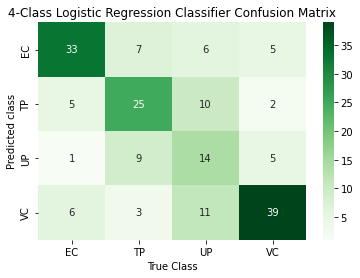

In [10]:
# Confusion matrix for Multinomial Logistic Regression
# Intersectionss between predicted and true class represent true positives for a given class
# Parts of a row for the predicted class that don't match the True class are false negatives.
# Parts of a column where the True class wasn't picked are false positives.
# Lastly, relative to the other three for a given class, any other box represents a true negative

kf = KFold(n_splits=10,shuffle = True)
X_processed, y_processed = process_data_etuv(X,y)

# Use cross_val_predict to get y_pred
kf = KFold(n_splits=10,shuffle = True)
LR.fit(X_processed, y_processed)
y_pred = cross_val_predict(LR, X_processed, y_processed, cv = kf) # gives us the matrix with inaccuracies

# Plotting and formatting the confusion matrix
MLR_CM = confusion_matrix(y_pred,y_processed)
ax = sns.heatmap(MLR_CM, annot=True, cmap='Greens')

#Labeling classes in the CM
classes = ["EC","TP","UP","VC"]
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set(title = "4-Class Logistic Regression Classifier Confusion Matrix",
       xlabel = "True Class",
       ylabel = "Predicted class")

We observed similar true positive results for EC,TP, and VC patients, as the actual paper. Similar to the paper, we found that it was common for the model to make false positive predictions for UP patients, where it misclassified them as TP and VC. This was attributed to similarities in their humoral profiles, that made it hard to distinguish these three groups from one another overall

# Figure 2D, probability scores 

Probability scores serve as a measure of the model's confidence in predicting a given patient's actual class. The sklearn cross_val_predict function returns an array, where each row is a patient and each column is the model's probability of predicting the patient as one of the four classes. Here, we plotted only the cross_val_predict score for a patient's true class, while coloring the class the model predicted them to be

In [11]:
# Part of multinomial logistic regression
# Determines the prediction probability for true class of each patient 

#fits model to processed/label encoded data
LR.fit(X_processed, y_processed)

# creates a new dataframe containing the predicted probabilities, with 4 columns representing the class prediction probability
df = pd.DataFrame(LR.predict_proba(X_processed))
df["class.etuv"] = np.array(y["class.etuv"])

# getting the labels associated with the numbers after label encoding
le = LabelEncoder() #used for converting data into numbers
y_processed = np.array(le.fit_transform(y["class.etuv"])) 
le_name_mapping = dict(zip( le.transform(le.classes_),le.classes_)) # makes a dictionary connecting label encoded numbers with their respective classess

# edits the table so that the dataframe is easier to work with later on
for i in range (4): #renames label encoded classes to their actual class name (0 --> "EC")
    df.rename(columns = {i:le_name_mapping[i]},inplace=True)
df.rename(columns = {"class.etuv":"True Class"},inplace=True) # will store the actual class of each data point

# predicts class with cross_val_predict, and converts them to the class' actual name
le_vals = cross_val_predict(LR, X_processed, y_processed, cv = kf) 
df["Predicted Class"] = [le_name_mapping[le_val] for le_val in le_vals] #converts label encoded value back to class name

# will match the predicted probability from the predicted proba columns with the true class at each data point
df["Probability of being true class"] = np.nan
for i in range(len(y_processed)):
    current_true_class = le_name_mapping[y_processed[i]] # true class of the current index
    df["Probability of being true class"][i] = df.iloc[i][current_true_class] # sets it to the predicted probability of the true clas for the current data point
df

,EC,TP,UP,VC,True Class,Predicted Class,Probability of being true class
0,0.894384,0.000127,0.047870,0.057619,EC,VC,0.894384
1,0.134016,0.742019,0.118125,0.005840,TP,TP,0.742019
2,0.004594,0.004111,0.010964,0.980331,VC,VC,0.980331
3,0.015189,0.951493,0.031271,0.002048,TP,TP,0.951493
4,0.930395,0.012740,0.035441,0.021423,EC,EC,0.930395
...,...,...,...,...,...,...,...
176,0.928928,0.033115,0.006635,0.031322,EC,EC,0.928928
177,0.021810,0.829642,0.076976,0.071573,TP,UP,0.829642
178,0.127090,0.032388,0.102809,0.737713,VC,EC,0.737713
179,0.546629,0.096716,0.037070,0.319586,EC,VC,0.546629


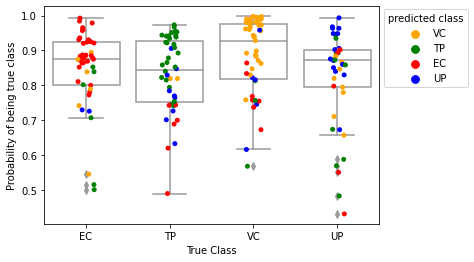

In [12]:
fig,ax = plt.subplots(1)

colormap = {
    "EC":"red",
    "TP":"green",
    "UP":"blue",
    "VC":"orange"
}
# Plots based divided by true class, with the color repreenting the predicted class (and its probability) 
sns.stripplot(y ="Probability of being true class", x = "True Class",hue = "Predicted Class", data= df, palette = colormap)
sns.boxplot(y ="Probability of being true class", x = "True Class", data= df,color= "white")

# formatting to move the legend to the upper right outisde the box
plt.legend(title = "predicted class",loc = "upper right",bbox_to_anchor=(1.28, 1.01))

##### Note: Color represents what the Multinomial Logistic Regression predicted the data point to be, and the column/boxplot is the patient's actual class

# Figure 3A

Between viremic and aviremic patients, the researchers plotted and compared the proportion of glycan bisection, among HIV-specific IgG antibodies and among all IgG antibodies between viremic and aviremic patients. I was able to find the total IgG bisection, but the value for HIV-specific IgG composition was unclear in the dataset. Here, I interpreted it to mean that they summed the bisected glycan columns (excluding B.total), and divided those values by the sum of all non-total columns, in order to get HIV-specific IgG compositions.

In [13]:
#Figure 3A

# 1. group glycan data by:

# two data tables, the glycan experimental variable data and their labels
glycan_data = pd.read_csv("dataset_EV1/data/glycan-gp120.csv").set_index("Unnamed: 0")
glycan_data.head()
hiv_specific_data = glycan_data.drop(["G0.total","G1.total","G2.total","F.total","B.total","S.total"],axis = 1)

# The total of the non-total columns in a row
#hiv_specific_data ["Sum of HIV-Specific IgG Abundances"] = hiv_specific_data.apply(np.sum,axis=1)
hiv_specific_data
totalHIV_spec = hiv_specific_data.apply(np.sum,axis=1)


In [14]:
glycan_labels =  pd.read_csv("dataset_EV1/meta/glycans.csv") #metadata
glycan_labels

,Unnamed: 0,b,s,g,f
0,G2FB,b,false,g2,f
1,G2F,false,false,g2,f
2,G2B,b,false,g2,false
3,G1FB,b,false,g1,f
4,G1F,false,false,g1,f
5,G1B,b,false,g1,false
6,G0FB,b,false,g0,f
7,G1,false,false,g1,false
8,G0F,false,false,g0,f
9,G0B,b,false,g0,false


In [15]:
b_column = glycan_labels["b"] # tells us the glycans that are bisected, indicated by a value of "b"
all_glycan_labels = glycan_labels["Unnamed: 0"] #stores all glycan labels ("G2FB","G2F", etc regardless of bisection)
bisected_label = [] # will only store labels with "b" in the b column of the glycan metadaata

#iterates through b column, recordng the rows labeled with "b"
for index in range(len(b_column)):
    if b_column[index] == "b": #checks if the row label is "b" for bisected glycan
        bisected_label.append(all_glycan_labels[index]) # adds the glycan variable name to the list 
# remove the last glycan label, which corresponds with "B.total", so we can get a df of only HIV-specific glycans
bisected_label.pop() 

# For each row, calculate the HIV-specific glycan bisection by
# taking the sum of the bisected HIV-specific glycans and 
# dividing them by the sum of all HIV-specific glycans within 
# a row (excludes columns with ".total" in the name)
# then multiplying by 100 to get the percentage
hiv_spec_bg  = glycan_data[bisected_label]
hiv_spec_bg["HIV-Specific Tot"]  =100 * (hiv_spec_bg.apply(np.sum,axis = 1) / totalHIV_spec)
hiv_spec_bg


,G2FB,G2B,G1FB,G1B,G0FB,G0B,G2S1B,G2S2FB,G2S2B,HIV-Specific Tot
Unnamed: 0,,,,,,,,,,
100681,0.1,0.7,3.5,3.3,0.4,1.1,0.3,1.2,0.5,11.909871
101013,0.7,0.5,7.0,7.4,5.9,7.8,0.5,0.5,0.8,33.191035
103797,0.3,0.2,10.8,6.7,7.0,7.9,0.4,0.7,1.3,37.473461
113706,0.2,0.3,2.7,2.0,0.3,3.6,0.3,1.1,2.3,13.704497
128522,0.1,0.7,6.8,6.4,0.4,1.8,0.2,1.4,0.0,19.078242
...,...,...,...,...,...,...,...,...,...,...
975508,0.0,0.1,4.7,4.7,0.1,1.4,1.1,0.0,9.2,22.350472
976531,0.8,0.4,10.3,2.2,2.8,3.4,1.1,1.5,1.2,25.000000
985170,0.1,0.7,5.8,2.1,2.2,3.8,0.5,2.3,1.6,19.937370


In [16]:
# "B.total" data points, or the total bisection among the patient's total IgG
total_bg = glycan_data["B.total"]

#removes NaNs for subjects that had no glycan measurements
df_tot = pd.concat([total_bg,y],axis = 1).dropna(axis=0) 
df_HS = pd.concat([hiv_spec_bg,y],axis = 1).dropna(axis=0)


(-1.92, 50.0)

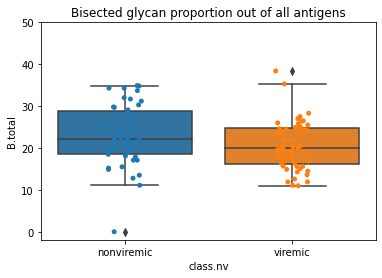

In [17]:
# Plotting total glycan bisection percentage
sns.boxplot(y = "B.total",
            x ="class.nv" ,
            data = df_tot,
            ).set(title = "Bisected glycan proportion out of all antigens")
sns.stripplot(y = "B.total",
            x ="class.nv" ,
            data = df_tot,
            ).set_ylim(top = 50)


(0.0, 50.0)

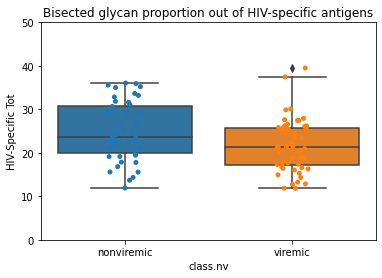

In [18]:
# Plotting HIV-specific bisection percentage
sns.boxplot(y = "HIV-Specific Tot",
            x ="class.nv" ,
            data = df_HS,
            ).set(title = "Bisected glycan proportion out of HIV-specific antigens")
sns.stripplot(y = "HIV-Specific Tot",
              x ="class.nv", 
              data = df_HS  
             ).set_ylim(bottom = 0,top = 50)


The figure also included 2-tailed significance bars between the distributions shown on figure 2A. I wasn't sure how to implement this while doing the project, so I just presented the uncorrected two-tailed T-test p-value between the distributions that had significant differences in the paper:

In [19]:
# Bisected glycan percentages of total IgG
v_tot_bis = df_tot[df_tot["class.nv"]=="viremic"]["B.total"]
av_tot_bis = df_tot[df_tot["class.nv"]=="nonviremic"]["B.total"]

# Bisected glycan percentages of HIV-specific IgG
v_hiv_bis = df_HS[df_HS["class.nv"]=="viremic"]["HIV-Specific Tot"]
av_hiv_bis = df_HS[df_HS["class.nv"]=="nonviremic"]["HIV-Specific Tot"]

# Carries out uncorrected two-tailed unpaired t-test for each combination of groups:

# Total glycan bisection proportions between nonviremic and viremic patients
av_tot_v_tot_pval = ttest_ind(av_tot_bis,v_tot_bis,alternative='two-sided').pvalue

# HIV-specific glycan bisection proportions between nonviremic and viremic patients
av_hiv_v_hiv_pval = ttest_ind(av_hiv_bis,v_hiv_bis,alternative='two-sided').pvalue

# HIV-specific glycan bisection for nonviremic patients vs total glycan bisection for nonviremic patients
av_hiv_av_tot_pval = ttest_ind(av_hiv_bis,av_tot_bis,alternative='two-sided').pvalue

# presenting and formating T-test results
template ="{0} {1} bisected glycans vs {2} {3} bisected glycans pvalue: {4}"
print(template.format("AV","Total","V","Total",av_tot_v_tot_pval))
print(template.format("AV","HIV-specific","V","HIV-Specific",av_hiv_v_hiv_pval))
print(template.format("AV","HIV-specific","AV","Total",av_hiv_av_tot_pval))


AV Total bisected glycans vs V Total bisected glycans pvalue: 0.05466690334071025
AV HIV-specific bisected glycans vs V HIV-Specific bisected glycans pvalue: 0.015238585935999742
AV HIV-specific bisected glycans vs AV Total bisected glycans pvalue: 0.24150928642451489


Given a = 0.05, the only significant difference was in the HIV-specific glycan bisection between Aviremic and Viremic patients.

On the other hand, given a p-value greater than 0.05, the differences in total glycan bisection between Aviremic and Viremic patients was not significant in our reimplementation. For similar reasons, the difference in total glycan bisection and HIV-specific glycan bisection withing aviremic patients was also not statistically significant

# Figure 3B

Results from an Fc array, which measures immune response magnitudes using a particular detection reagent and antigen. Galit et al.compared measurements of the same variable between EC and TP patients using uncorrected independent 2-tailed T-tests between their respective antigen-detection measurements, and plotted the significance (log10 p-value) of the difference and the ratio between the mean of the measurements for the two groups (log2 fold change) on a volcano plot.


In [20]:
# metadata tables
detect_meta = pd.read_csv("dataset_EV1/meta/detections.csv") # lists the detection reagent used and the group it falls under
antigen_meta = pd.read_csv("dataset_EV1/meta/antigens.csv") # listss the antigen used an the group it falls under

# detections table
lumigg = pd.read_csv("./dataset_EV1/data/luminex-igg.csv").set_index("Unnamed: 0")
lumi =pd.read_csv("./dataset_EV1/data/luminex.csv").set_index("Unnamed: 0")
antibody_readings = pd.concat([lumi,lumigg],axis = 1)

# represents all unique Fc array conditions as a string containing their antigen specificities and the detection
conditions = np.array(antibody_readings.columns,dtype = str)
# will look like: array(['C1q.6H.HIV1.p66', 'C1q.gp120.96ZM651', 'C1q.gp120.BAL', ... 'IgG.p24.IIIb', 'IgG.SOSIP'],dtype='<U34')

# combines all data relaated to Fc array readings as well as the four patient classes, matched by data point
fc_array_all_class = pd.concat([lumi,lumigg,y["class.etuv"]],axis = 1)

# removes data points falling under "VC" and "UP"
fc_arr_TP_EC = fc_array_all_class[(fc_array_all_class["class.etuv"] == "TP") | (fc_array_all_class["class.etuv"] == "EC")]
fc_arr_TP_EC 

,C1q.6H.HIV1.p66,C1q.gp120.96ZM651,C1q.gp120.BAL,C1q.gp120.BAL.Kif,C1q.gp120.CM,C1q.gp120.CN54,C1q.gp120.Du151,C1q.gp120.Du156.12,C1q.gp120.IIIb,C1q.gp120.JRCSF,...,IgG.gp41.HXBc2,IgG.IIIb.pr55.Gag,IgG.HIV1.Integrase,IgG.HIV1.Nef,IgG.HIV1.Rev,IgG.HIV1.Vif,IgG.p24.HXBc2,IgG.p24.IIIb,IgG.SOSIP,class.etuv
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
100681,100276.0,4.3,545.5,18.7,17.2,-20.0,6.2,-27.8,-8.5,184.5,...,196446.0,2804.0,197194.5,159252.0,26876.0,8268.5,158492.0,165700.5,116198.0,EC
101013,1107.5,-3.7,3.5,0.2,2.7,-3.5,-5.8,-21.8,12.0,1.5,...,184816.0,692.0,183272.5,20047.5,798.5,2520.5,13425.0,22777.0,51587.0,TP
107889,-78.0,3.8,2.5,1.2,-2.8,7.5,-17.8,-12.8,-7.0,-1.0,...,185115.0,251.0,52808.0,934.0,700.5,2190.0,6452.0,5289.0,44045.0,TP
109477,17445.0,-10.7,-6.5,3.7,-4.8,4.5,-6.3,-34.8,-3.5,-14.5,...,187718.0,1674.0,179726.0,4714.0,1637.5,6801.5,132180.5,140471.5,34257.5,EC
113706,10571.0,-2.2,-11.5,10.7,-12.8,4.5,-10.8,-31.8,-1.0,2.5,...,191379.0,935.0,185898.0,6329.0,487.5,2564.0,162085.0,149994.0,16305.0,EC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975508,129981.0,2.8,-19.0,-3.8,-3.3,-4.5,4.2,-14.8,11.5,4.5,...,192991.0,2452.0,198138.5,40958.5,2202.0,7073.0,175914.5,173174.0,74018.0,EC
976531,17852.5,-5.2,-1.5,-4.3,-5.3,-1.5,-4.8,-20.8,4.5,7.5,...,184401.0,2231.0,184700.5,101539.0,40291.0,6548.0,182282.0,185392.0,99881.0,EC
985170,119551.0,3.8,18.5,5.7,0.7,5.5,10.2,-20.8,7.5,34.5,...,193935.5,2193.0,195329.0,19253.0,145227.0,6352.0,146021.5,136476.0,72130.0,TP


In [21]:
# creating a table in pandas format to make plotting with seaborn easy
volcano_table = pd.DataFrame({"conditions":conditions})

# creating empty columns to store p-value and fold change data,
# as well as metadata for that particular condition for plottng w/ sns
volcano_table["- log10(pval)"]= np.nan
volcano_table["log2(Fold Change) (EC/TP)"]= np.nan
volcano_table["Antigen Specificity"] = np.nan
volcano_table["Detection Reagent"]= np.nan

#### Functions for helping calculate and label the data needed for completing the volcano plot:

In [22]:
# Step 1: given a condition name ("C1q.6H.HIV1.p66"), get the info about the detection and antigen used ["C1q","HIV-other"]

test_str = "C1q.6H.HIV1.p66"
def find_det_anti_groups(condition):
    """
    Given a string in the form "C1q.6H.HIV1.p66"
    representing a treatment, determines the 
    detection type and antigen associated with 
    the condition
    given:"C1q.6H.HIV1.p66", returns ["C1q","HIV-other"]
    
    condition: a string containing the detection
    and antigen used in the variable separated 
    by one period
    
    @return: an list containing the antigen group
    """
    # split the inputted string by the first period only
    # first item is the detection, second item the antigen
    # "C1q.6H.HIV1.p66" --> ['C1q', '6H.HIV1.p66']
    
    # Note: this split() strategy mostly works assuming the detection string has no periods itself,
    # since i couldn't find a good fix in time, I just hardcoded the exceptions 
    det_is_not_an_exception = True
    det_anti_list = []
    det_exceptions = ["FcgRIIa.H131","FcgRIIa.R131","FcgRIIIa.F158","FcgRIIIa.V158","FcgRIIIb.NA1","FcgRIIIb.SH"]
    for det in det_exceptions: # iterates through all detection exceptions (those that include a period in the name)
        if det in condition:
            anti = condition.replace(det+".","") # removes the detection part of the string to get the antigen part
            det_anti_list = [det,anti]
            det_is_not_an_exception = False
    if det_is_not_an_exception:
        det_anti_list = condition.split(".",1)
    
    # note: detect_meta and antigen_meta are globally defined pd dataframe variables
    
    # getting the string for the group that a detection falls under
    det_group = detect_meta['group'].where(detect_meta['detection'] == det_anti_list[0]).dropna().values[0]    
    
    # getting the string for the group that an antigen falls under
    anti_group = antigen_meta['group'].where(antigen_meta['antigen'] == det_anti_list[1]).dropna().values[0]
    
    return [det_group,anti_group]

# Step 2 function: for helping calculating log10 and fold change

def get_condition_array(df,col):
    """
    Calculates and returns an array
    of the uncorrected data for a given group
    (expected to either be "TP" or "EC")
    
    
    df: some dataframe that either only contains "TP"
    or "VC" data ponts
    col: a string representing the name of the current
    condition to return an array for (i.e "IgG.gp41.HXBc")
    """
    
    return np.array(df[col])

In [23]:
for i in range(len(conditions)): 
    # Step 1: label the antigen specificity and detection reagent for each condition
    
    # a list containing the detection and antigen group, based on the condition name
    det_anti_list = find_det_anti_groups(conditions[i])
    volcano_table.loc[i,["Detection Reagent",'Antigen Specificity']] = det_anti_list
    
    # Step 2: calculating the log10(pval) and log2(Fold Change) for the condition
     # a list containing the detection group and
    tp_ec_series = fc_arr_TP_EC.groupby("class.etuv").apply(get_condition_array,conditions[i])
    tp_arr = tp_ec_series["TP"]
    ec_arr = tp_ec_series["EC"]
    log10_pval = -np.log10(ttest_ind(tp_arr,ec_arr,alternative='two-sided').pvalue)
    log2_fold_change = np.log2(np.mean(ec_arr)/np.mean(tp_arr))
       
    
    volcano_table.loc[i,["- log10(pval)","log2(Fold Change) (EC/TP)"]] = [log10_pval,log2_fold_change]
volcano_table

,conditions,- log10(pval),log2(Fold Change) (EC/TP),Antigen Specificity,Detection Reagent
0,C1q.6H.HIV1.p66,0.161565,0.191886,HIV-other,C1q
1,C1q.gp120.96ZM651,1.700730,1.128695,gp120,C1q
2,C1q.gp120.BAL,0.265151,NaN,gp120,C1q
3,C1q.gp120.BAL.Kif,0.261675,-0.349496,gp120,C1q
4,C1q.gp120.CM,0.396129,-2.275278,gp120,C1q
...,...,...,...,...,...
512,IgG.HIV1.Rev,0.112349,0.306674,HIV-other,IgG
513,IgG.HIV1.Vif,0.589330,-0.201666,HIV-other,IgG
514,IgG.p24.HXBc2,2.633095,0.928366,p24,IgG
515,IgG.p24.IIIb,2.826255,0.971618,p24,IgG


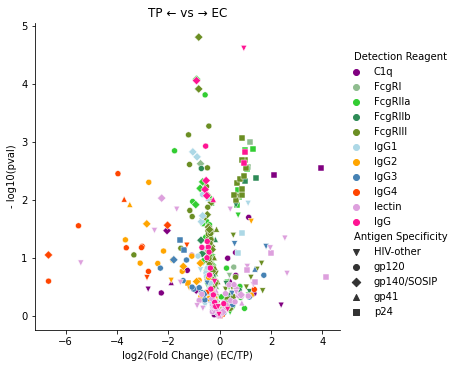

In [24]:
# Note: in the meta data for antigen_shape, the glycan data seems to not be included
antigen_shape = { #dictionaryfor plotting shape
    "HIV-other":"v", #replaces upside down arrow from paper
    "gp120":"o", #circle
    "gp140/SOSIP":"D", #diamond
    "gp41":"^", #triangle
    "p24":"s" #square
}

# Note: in the metadata for detections, "Glycan" was excluded, and instead there's a group called "IgG"
# Some colors also changed since the ones listed in the dataset were unavailable in matplotlib
color_dict = { #dictionary for plotting color, copied from color.csv
    "FcgRI":"darkseagreen",
    "FcgRIII":"olivedrab",
    "FcgRIIa":"limegreen",
    "FcgRIIb":"seagreen",
    "IgG":"deeppink",
    "IgG1":"lightblue",
    "IgG2":"orange",
    "IgG3":"steelblue",
    "IgG4":"orangered",
    "C1q":"purple",
    "lectin":"plum"
    
}

plt = sns.relplot(
    data = volcano_table,x = "log2(Fold Change) (EC/TP)",y = "- log10(pval)",
    hue = "Detection Reagent",
    style = "Antigen Specificity",
    markers = antigen_shape,
    palette =color_dict )

#formatting title
plt.set(title = "TP ← vs → EC")


Here, fold change was the ratio between the means of data between EC and TP patients (EC/TP)

# Random Forest Analysis

As an extension of the analysis for the paper, we applied a random forest classifier to the same data used for logistic regression, and compared our accuracies. We cross validated for the number of trees, then using that same parameter, cross validated for max_depth, both with ranges between 1-100. 

In [25]:
# Random forest extension

X_processed, y_processed = process_data_etuv(X,y)

# Cross Validation for the best value of max_depth

N=100 #largest max depth/n_estimator

best_n_estimators = 0
best_ne_score=-np.inf
ne_scores=np.zeros(N)

best_depth = 0
best_depth_score = -np.inf
depth_scores=np.zeros(N)

#Cross validating for number of estimators/trees
for ne in range(1,N+1): #iterates through values 1 - 40 to use as the number of estimators for of the model
    
    RF = RandomForestClassifier(n_estimators=ne)
    
    #adds the average score in 10 folds to the list 
    # ne-1 since the range starts at 1
    
    ne_scores[ne-1]=cross_val_score(RF,X_processed,y_processed,cv=kf).mean()
    
    # if the current score is better, replaces the best recorded best_ne_score with current one
    if ne_scores[ne-1]>best_ne_score:
        best_n_estimators=ne #sets the best estimator
        best_ne_score=ne_scores[ne-1] # record its score
        
#Cross validating for the max depth of the trees

N = 100
for d in range(1,N+1): #iterates through values 1 - 40 to use as the the max depth of the model
    
    RF = RandomForestClassifier(max_depth=d,n_estimators=best_n_estimators)
    
    #adds the average score in 10 folds to the list 
    depth_scores[d-1]=cross_val_score(RF,X_processed,y_processed,cv=kf).mean()
    if depth_scores[d-1]>best_depth_score: # if the current score is better, replaces the best recorded depth with current
        best_depth=d
        best_depth_score=depth_scores[d-1]

template_ne = "Best n_estimators: {0} (score = {1})"
template_d = "Best max_depth: {0} (score = {1})"

print(template_ne.format(best_n_estimators,best_ne_score))
print(template_d.format(best_depth,best_depth_score))

Best n_estimators: 82 (score = 0.612280701754386)
Best max_depth: 92 (score = 0.5903508771929824)


Here, we recreated the accuracy-testing process from Figure 2A, but using a cross-validated Random Forest model, instead of multinomial Logistic Regression

In [26]:
kf = KFold(n_splits=10,shuffle = True)
avg_RF_scores = []
X_processed, y_processed = process_data_etuv(X,y)

# 100 cross validations of RF accuracy for the best_depth/num_estimators determined in previous step

# full model accuracy 
for cv_iteration in range(100):
    k_10_scores = []
    for i, (train_index, test_index) in enumerate(kf.split(X_processed)):

        # random indeces for training set
        x_train = X_processed.loc[train_index]
        y_train = y_processed[train_index] # don't use loc ssince it's a 1D array

        # remaining indeces for test set
        x_test =  X_processed.loc[test_index]
        y_test = y_processed[test_index] 

        # Fits training set
        RF = RandomForestClassifier(max_depth=best_depth,n_estimators=best_n_estimators)        
        RF.fit(x_train,y_train)
        
        # Calculates the score for the current fold and adds it to k_10_scores
        k_10_scores.append(RF.score(x_test,y_test))
    
    #calculates the means of accuracies of the 10 folds and records it in avg_scores
    avg_RF_scores.append(np.mean(np.array(k_10_scores)))

#permuted data accuracies (expected: ~0.25)
score_RF_rand = permutation_test_score(RF, X_processed, y_processed, scoring="accuracy", cv=kf, n_permutations=100)
 

[Text(0.5, 1.0, '4-Class Logistic Regression and Random Forest Models'),
 Text(0, 0.5, 'Accuracy')]

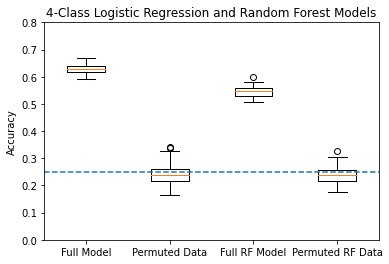

In [27]:
from matplotlib import pyplot as plt
# for some reason, matplotlib doesn't work when this box runs,
# so i re-imported it
fig,ax = plt.subplots(1)
permuted_RF_scores = score_RF_rand[1]
df = pd.DataFrame({"Full LR Model":scores,
                   "Permuted LR Data":permuted_scores,
                   "Full RF Model":avg_RF_scores,
                   "Permuted RF Data":permuted_RF_scores
                  })
labels = ["Full Model","Permuted Data","Full RF Model","Permuted RF Data"]

ax.boxplot(df, labels=labels) # plots full model and permuted data model
plt.axhline(.25, linestyle="dashed") # baseline


#formatting
ax.set_ylim(0.0,0.8)
ax.set(
    title = "4-Class Logistic Regression and Random Forest Models",
    ylabel = "Accuracy",

)

[Text(0.5, 1.0, '4-Class Random Forest Classifier Confusion Matrix'),
 Text(0.5, 15.0, 'True Class'),
 Text(33.0, 0.5, 'Predicted class')]

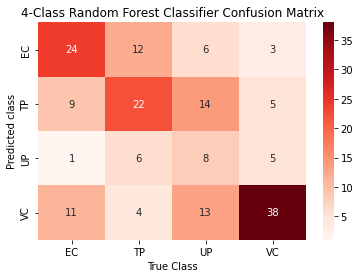

In [28]:

X_processed, y_processed = process_data_etuv(X,y)
kf = KFold(n_splits=10,shuffle = True)
RF = RandomForestClassifier(max_depth=best_depth)   

RF.fit(X_processed, y_processed)
y_pred = cross_val_predict(RF, X_processed, y_processed, cv = kf)

# Plotting and formatting the confusion matrix
MLR_CM = confusion_matrix(y_pred,y_processed)
ax = sns.heatmap(MLR_CM, annot=True, cmap='Reds')

#Labeling classes in the CM
classes = ["EC","TP","UP","VC"]
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set(title = "4-Class Random Forest Classifier Confusion Matrix",
       xlabel = "True Class",
       ylabel = "Predicted class")

Our cross validation process yielded different parameters each time the code ran. We also found that the random forests performed worse in accuracy compared to multinomial logistic regression, when we conducted 100 repeats of 10-fold accuracy, as was done for Fig.2A. We also noted comparatively less confidence for predicting true classes in the confusion matrix. We concluded that random forest models were unreliable for predicting the four patient classes. 